In [1]:
import os
import pickle

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter 

from experiment_details import ExperimentDetails
from parse_input import parse_xml, parse_itc2007_curriculum_based, parse_itc2007_post_enrolment
from penalty_calc import calculate_total_cost


In [2]:
experiment_folder = 'D:\Desktop\done tests\itc2019_depth_first_search_test_20240309-153858'

itc2007_track2_path = 'D:\\Desktop\\Datasets\\post'
itc2007_track3_path = 'D:\\Desktop\\Datasets\\curriculum'
itc2019_path = 'D:\\Desktop\\Datasets\\2019'

In [3]:
def get_all_files(path):
    return [os.path.join(dirpath, file) for dirpath, _, filenames in os.walk(path) for file in filenames]    

In [4]:
itc2007_track2_files = get_all_files(itc2007_track2_path)
itc2007_track3_files = get_all_files(itc2007_track3_path)
itc2019_files = get_all_files(itc2019_path)

In [5]:
def get_instance_by_dataset_and_instance_file_name(dataset, instance_file_name):
    if dataset == 'itc2007_track2':
        return next((file for file in itc2007_track2_files if instance_file_name in file), None)
    elif dataset == 'itc2007_track3':
        return next((file for file in itc2007_track3_files if instance_file_name in file), None)
    elif dataset == 'itc2019':
        return next((file for file in itc2019_files if instance_file_name+".xml" in
 file.split("\\\\")[-1]), None)
    else:
        return None
    
def parse_problem (dataset,instance_path):
    if dataset == 'itc2007_track2':
        return parse_itc2007_post_enrolment(instance_path)
    elif dataset == 'itc2007_track3':
        return parse_itc2007_curriculum_based(instance_path)
    elif dataset == 'itc2019':
        return parse_xml(instance_path)

In [6]:
analysis_df = pd.DataFrame(list(os.listdir(experiment_folder)),columns=['folder'])

In [7]:
analysis_df['folder path']=analysis_df.apply(lambda x: os.path.join(experiment_folder,x.folder),axis=1) 

analysis_df

,folder,folder path
0,agh-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...
1,agh-fis-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...
2,agh-ggis-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...
3,agh-ggos-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...
4,agh-h-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...
5,bet-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...
6,bet-spr18,D:\Desktop\done tests\itc2019_depth_first_sear...
7,iku-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...
8,iku-spr18,D:\Desktop\done tests\itc2019_depth_first_sear...
9,lums-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...


In [8]:
analysis_df['experiment_details'] = analysis_df.apply(lambda x: pickle.load(open(os.path.join(x['folder path'],'experiment_details.pkl'), 'rb')),axis=1)

analysis_df

,folder,folder path,experiment_details
0,agh-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...
1,agh-fis-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...
2,agh-ggis-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...
3,agh-ggos-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...
4,agh-h-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...
5,bet-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...
6,bet-spr18,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...
7,iku-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...
8,iku-spr18,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...
9,lums-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...


In [9]:
analysis_df['instance_name'] = analysis_df.apply(lambda x: x.experiment_details.instance_name,axis=1)

analysis_df

,folder,folder path,experiment_details,instance_name
0,agh-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-fal17
1,agh-fis-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-fis-spr17
2,agh-ggis-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-ggis-spr17
3,agh-ggos-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-ggos-spr17
4,agh-h-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-h-spr17
5,bet-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,bet-fal17
6,bet-spr18,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,bet-spr18
7,iku-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,iku-fal17
8,iku-spr18,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,iku-spr18
9,lums-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,lums-fal17


In [10]:
analysis_df['instance_file'] = analysis_df.apply(lambda x: get_instance_by_dataset_and_instance_file_name(x.experiment_details.dataset_name, x.experiment_details.instance_file_name), axis=1)

analysis_df

,folder,folder path,experiment_details,instance_name,instance_file
0,agh-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-fal17,D:\Desktop\Datasets\2019\3.late\agh-fal17.xml
1,agh-fis-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-fis-spr17,D:\Desktop\Datasets\2019\1.early\agh-fis-spr17...
2,agh-ggis-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-ggis-spr17,D:\Desktop\Datasets\2019\1.early\agh-ggis-spr1...
3,agh-ggos-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-ggos-spr17,D:\Desktop\Datasets\2019\2.middle\agh-ggos-spr...
4,agh-h-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-h-spr17,D:\Desktop\Datasets\2019\2.middle\agh-h-spr17.xml
5,bet-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,bet-fal17,D:\Desktop\Datasets\2019\1.early\bet-fal17.xml
6,bet-spr18,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,bet-spr18,D:\Desktop\Datasets\2019\3.late\bet-spr18.xml
7,iku-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,iku-fal17,D:\Desktop\Datasets\2019\1.early\iku-fal17.xml
8,iku-spr18,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,iku-spr18,D:\Desktop\Datasets\2019\3.late\iku-spr18.xml
9,lums-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,lums-fal17,D:\Desktop\Datasets\2019\3.late\lums-fal17.xml


In [11]:
analysis_df['problem'],analysis_df['problem_stats'] = zip(*analysis_df.apply(lambda x: parse_problem(x.experiment_details.dataset_name, x['instance_file']),axis=1))
analysis_df

,folder,folder path,experiment_details,instance_name,instance_file,problem,problem_stats
0,agh-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-fal17,D:\Desktop\Datasets\2019\3.late\agh-fal17.xml,<models.input.problem.Problem object at 0x0000...,"{'name': 'agh-fal17', 'student_count': 6925, '..."
1,agh-fis-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-fis-spr17,D:\Desktop\Datasets\2019\1.early\agh-fis-spr17...,<models.input.problem.Problem object at 0x0000...,"{'name': 'agh-fis-spr17', 'student_count': 164..."
2,agh-ggis-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-ggis-spr17,D:\Desktop\Datasets\2019\1.early\agh-ggis-spr1...,<models.input.problem.Problem object at 0x0000...,"{'name': 'agh-ggis-spr17', 'student_count': 21..."
3,agh-ggos-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-ggos-spr17,D:\Desktop\Datasets\2019\2.middle\agh-ggos-spr...,<models.input.problem.Problem object at 0x0000...,"{'name': 'agh-ggos-spr17', 'student_count': 22..."
4,agh-h-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-h-spr17,D:\Desktop\Datasets\2019\2.middle\agh-h-spr17.xml,<models.input.problem.Problem object at 0x0000...,"{'name': 'agh-h-spr17', 'student_count': 1988,..."
5,bet-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,bet-fal17,D:\Desktop\Datasets\2019\1.early\bet-fal17.xml,<models.input.problem.Problem object at 0x0000...,"{'name': 'bet-fal17', 'student_count': 3018, '..."
6,bet-spr18,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,bet-spr18,D:\Desktop\Datasets\2019\3.late\bet-spr18.xml,<models.input.problem.Problem object at 0x0000...,"{'name': 'bet-spr18', 'student_count': 2921, '..."
7,iku-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,iku-fal17,D:\Desktop\Datasets\2019\1.early\iku-fal17.xml,<models.input.problem.Problem object at 0x0000...,"{'name': 'iku-fal17', 'student_count': 0, 'avg..."
8,iku-spr18,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,iku-spr18,D:\Desktop\Datasets\2019\3.late\iku-spr18.xml,<models.input.problem.Problem object at 0x0000...,"{'name': 'iku-spr18', 'student_count': 0, 'avg..."
9,lums-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,lums-fal17,D:\Desktop\Datasets\2019\3.late\lums-fal17.xml,<models.input.problem.Problem object at 0x0000...,"{'name': 'lums-fal17', 'student_count': 0, 'av..."


In [12]:
analysis_df['success'] = analysis_df.apply(lambda x: x.experiment_details.results_data['success'],axis=1)

analysis_df['operation_count'] = analysis_df.apply(lambda x: x.experiment_details.results_data['operation_count'],axis=1)

analysis_df['backtrack_count'] = analysis_df.apply(lambda x: x.experiment_details.results_data['backtrack_count'],axis=1)

analysis_df['time'] = analysis_df.apply(lambda x: x.experiment_details.results_data['time'],axis=1)

analysis_df['operation_history'] = analysis_df.apply(lambda x: x.experiment_details.results_data['operation_history'],axis=1)

analysis_df

,folder,folder path,experiment_details,instance_name,instance_file,problem,problem_stats,success,operation_count,backtrack_count,time,operation_history
0,agh-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-fal17,D:\Desktop\Datasets\2019\3.late\agh-fal17.xml,<models.input.problem.Problem object at 0x0000...,"{'name': 'agh-fal17', 'student_count': 6925, '...",False,10000,4711,6059.258079,"[{'current_row': 1, 'time': 4.9310595989227295..."
1,agh-fis-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-fis-spr17,D:\Desktop\Datasets\2019\1.early\agh-fis-spr17...,<models.input.problem.Problem object at 0x0000...,"{'name': 'agh-fis-spr17', 'student_count': 164...",True,1403,82,1208.231879,"[{'current_row': 1, 'time': 1.7143049240112305..."
2,agh-ggis-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-ggis-spr17,D:\Desktop\Datasets\2019\1.early\agh-ggis-spr1...,<models.input.problem.Problem object at 0x0000...,"{'name': 'agh-ggis-spr17', 'student_count': 21...",False,10000,4788,494.706985,"[{'current_row': 1, 'time': 0.0749995708465576..."
3,agh-ggos-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-ggos-spr17,D:\Desktop\Datasets\2019\2.middle\agh-ggos-spr...,<models.input.problem.Problem object at 0x0000...,"{'name': 'agh-ggos-spr17', 'student_count': 22...",False,10000,4761,2040.007005,"[{'current_row': 1, 'time': 0.2239875793457031..."
4,agh-h-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-h-spr17,D:\Desktop\Datasets\2019\2.middle\agh-h-spr17.xml,<models.input.problem.Problem object at 0x0000...,"{'name': 'agh-h-spr17', 'student_count': 1988,...",False,10000,4945,3825.251846,"[{'current_row': 1, 'time': 0.3339982032775879..."
5,bet-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,bet-fal17,D:\Desktop\Datasets\2019\1.early\bet-fal17.xml,<models.input.problem.Problem object at 0x0000...,"{'name': 'bet-fal17', 'student_count': 3018, '...",True,7569,3293,712.574002,"[{'current_row': 1, 'time': 0.0479998588562011..."
6,bet-spr18,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,bet-spr18,D:\Desktop\Datasets\2019\3.late\bet-spr18.xml,<models.input.problem.Problem object at 0x0000...,"{'name': 'bet-spr18', 'student_count': 2921, '...",False,10000,4910,357.709757,"[{'current_row': 1, 'time': 0.0489997863769531..."
7,iku-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,iku-fal17,D:\Desktop\Datasets\2019\1.early\iku-fal17.xml,<models.input.problem.Problem object at 0x0000...,"{'name': 'iku-fal17', 'student_count': 0, 'avg...",False,10000,4388,2128.495530,"[{'current_row': 1, 'time': 0.3000011444091797..."
8,iku-spr18,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,iku-spr18,D:\Desktop\Datasets\2019\3.late\iku-spr18.xml,<models.input.problem.Problem object at 0x0000...,"{'name': 'iku-spr18', 'student_count': 0, 'avg...",False,10000,4464,3150.435143,"[{'current_row': 1, 'time': 0.3220019340515136..."
9,lums-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,lums-fal17,D:\Desktop\Datasets\2019\3.late\lums-fal17.xml,<models.input.problem.Problem object at 0x0000...,"{'name': 'lums-fal17', 'student_count': 0, 'av...",True,502,0,34.328587,"[{'current_row': 1, 'time': 0.2269876003265380..."


In [13]:
analysis_df['solution_gene_file'] = (
    analysis_df.apply(lambda x: 
        os.path.join(x['folder path'],'solution gene.npy') if x['success']
        else None,axis=1)
)
                                                      
analysis_df['solution_gene'] = analysis_df.apply(lambda x: 
    np.load(x['solution_gene_file']) if x['success']
    else None,axis=1)

analysis_df['cost'] = analysis_df.apply(lambda x:
    calculate_total_cost(x['problem'],x['solution_gene']) if x['success']
    else None,axis=1)

analysis_df


,folder,folder path,experiment_details,instance_name,instance_file,problem,problem_stats,success,operation_count,backtrack_count,time,operation_history,solution_gene_file,solution_gene,cost
0,agh-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-fal17,D:\Desktop\Datasets\2019\3.late\agh-fal17.xml,<models.input.problem.Problem object at 0x0000...,"{'name': 'agh-fal17', 'student_count': 6925, '...",False,10000,4711,6059.258079,"[{'current_row': 1, 'time': 4.9310595989227295...",None,None,None
1,agh-fis-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-fis-spr17,D:\Desktop\Datasets\2019\1.early\agh-fis-spr17...,<models.input.problem.Problem object at 0x0000...,"{'name': 'agh-fis-spr17', 'student_count': 164...",True,1403,82,1208.231879,"[{'current_row': 1, 'time': 1.7143049240112305...",D:\Desktop\done tests\itc2019_depth_first_sear...,"[[1, 165], [-1, 0], [-1, 0], [-1, 0], [-1, 0],...","(0, 7212)"
2,agh-ggis-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-ggis-spr17,D:\Desktop\Datasets\2019\1.early\agh-ggis-spr1...,<models.input.problem.Problem object at 0x0000...,"{'name': 'agh-ggis-spr17', 'student_count': 21...",False,10000,4788,494.706985,"[{'current_row': 1, 'time': 0.0749995708465576...",None,None,None
3,agh-ggos-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-ggos-spr17,D:\Desktop\Datasets\2019\2.middle\agh-ggos-spr...,<models.input.problem.Problem object at 0x0000...,"{'name': 'agh-ggos-spr17', 'student_count': 22...",False,10000,4761,2040.007005,"[{'current_row': 1, 'time': 0.2239875793457031...",None,None,None
4,agh-h-spr17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,agh-h-spr17,D:\Desktop\Datasets\2019\2.middle\agh-h-spr17.xml,<models.input.problem.Problem object at 0x0000...,"{'name': 'agh-h-spr17', 'student_count': 1988,...",False,10000,4945,3825.251846,"[{'current_row': 1, 'time': 0.3339982032775879...",None,None,None
5,bet-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,bet-fal17,D:\Desktop\Datasets\2019\1.early\bet-fal17.xml,<models.input.problem.Problem object at 0x0000...,"{'name': 'bet-fal17', 'student_count': 3018, '...",True,7569,3293,712.574002,"[{'current_row': 1, 'time': 0.0479998588562011...",D:\Desktop\done tests\itc2019_depth_first_sear...,"[[-1, 0], [30, 2], [31, 5], [28, 10], [29, 5],...","(0, 28960)"
6,bet-spr18,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,bet-spr18,D:\Desktop\Datasets\2019\3.late\bet-spr18.xml,<models.input.problem.Problem object at 0x0000...,"{'name': 'bet-spr18', 'student_count': 2921, '...",False,10000,4910,357.709757,"[{'current_row': 1, 'time': 0.0489997863769531...",None,None,None
7,iku-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,iku-fal17,D:\Desktop\Datasets\2019\1.early\iku-fal17.xml,<models.input.problem.Problem object at 0x0000...,"{'name': 'iku-fal17', 'student_count': 0, 'avg...",False,10000,4388,2128.495530,"[{'current_row': 1, 'time': 0.3000011444091797...",None,None,None
8,iku-spr18,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,iku-spr18,D:\Desktop\Datasets\2019\3.late\iku-spr18.xml,<models.input.problem.Problem object at 0x0000...,"{'name': 'iku-spr18', 'student_count': 0, 'avg...",False,10000,4464,3150.435143,"[{'current_row': 1, 'time': 0.3220019340515136...",None,None,None
9,lums-fal17,D:\Desktop\done tests\itc2019_depth_first_sear...,<experiment_details.ExperimentDetails object a...,lums-fal17,D:\Desktop\Datasets\2019\3.late\lums-fal17.xml,<models.input.problem.Problem object at 0x0000...,"{'name': 'lums-fal17', 'student_count': 0, 'av...",Tru

In [14]:
analysis_df['folder path']

0     D:\Desktop\done tests\itc2019_depth_first_sear...
1     D:\Desktop\done tests\itc2019_depth_first_sear...
2     D:\Desktop\done tests\itc2019_depth_first_sear...
3     D:\Desktop\done tests\itc2019_depth_first_sear...
4     D:\Desktop\done tests\itc2019_depth_first_sear...
5     D:\Desktop\done tests\itc2019_depth_first_sear...
6     D:\Desktop\done tests\itc2019_depth_first_sear...
7     D:\Desktop\done tests\itc2019_depth_first_sear...
8     D:\Desktop\done tests\itc2019_depth_first_sear...
9     D:\Desktop\done tests\itc2019_depth_first_sear...
10    D:\Desktop\done tests\itc2019_depth_first_sear...
11    D:\Desktop\done tests\itc2019_depth_first_sear...
12    D:\Desktop\done tests\itc2019_depth_first_sear...
13    D:\Desktop\done tests\itc2019_depth_first_sear...
14    D:\Desktop\done tests\itc2019_depth_first_sear...
15    D:\Desktop\done tests\itc2019_depth_first_sear...
16    D:\Desktop\done tests\itc2019_depth_first_sear...
17    D:\Desktop\done tests\itc2019_depth_first_

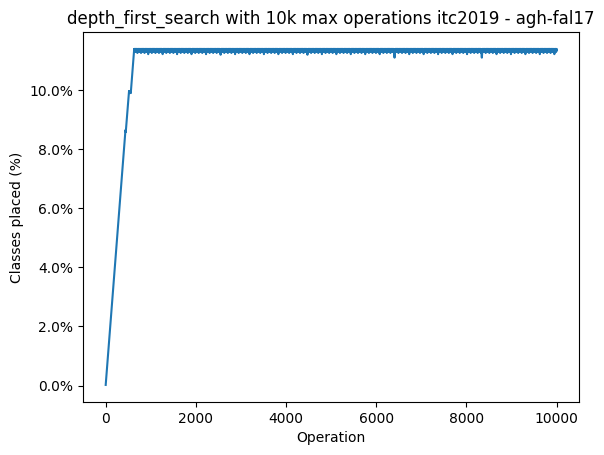

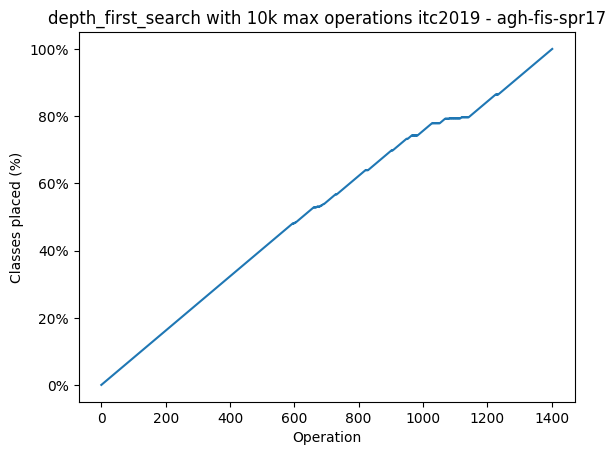

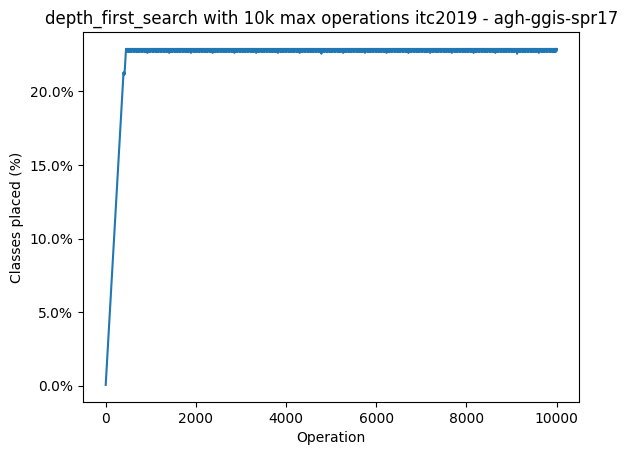

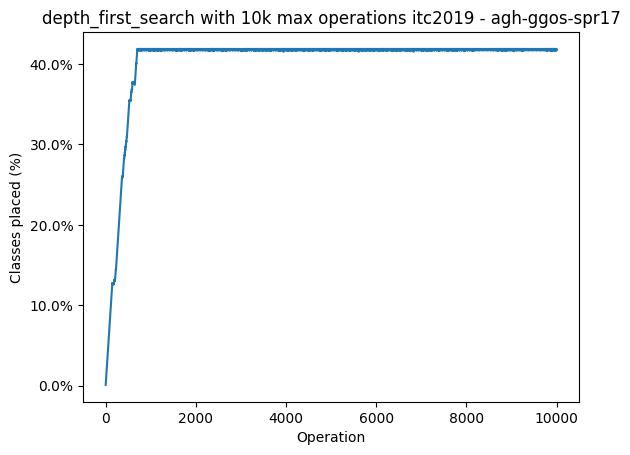

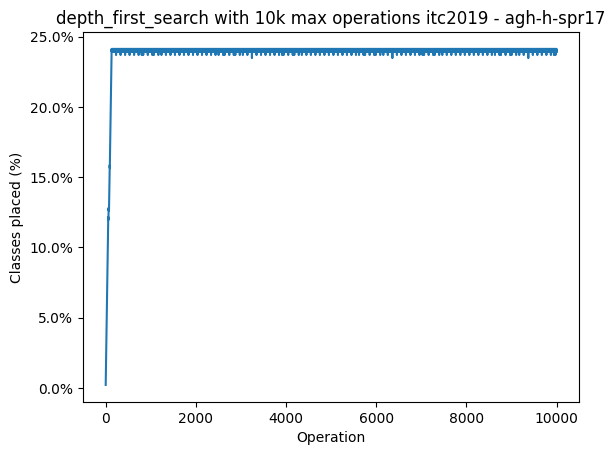

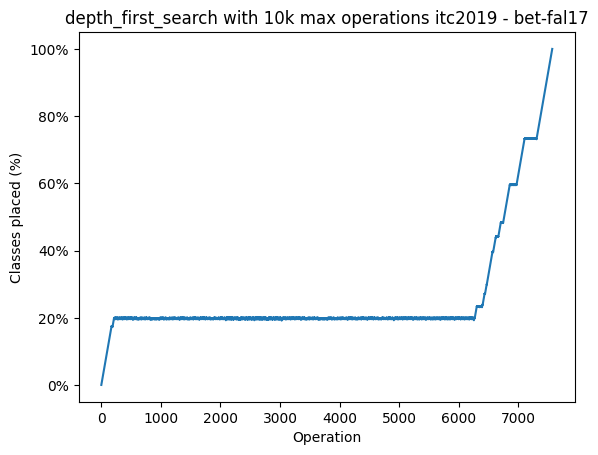

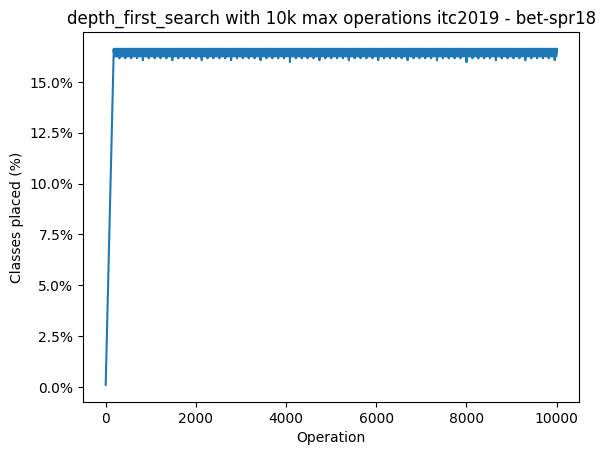

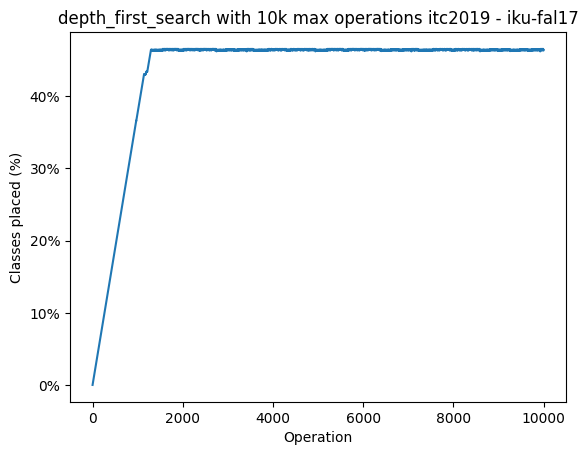

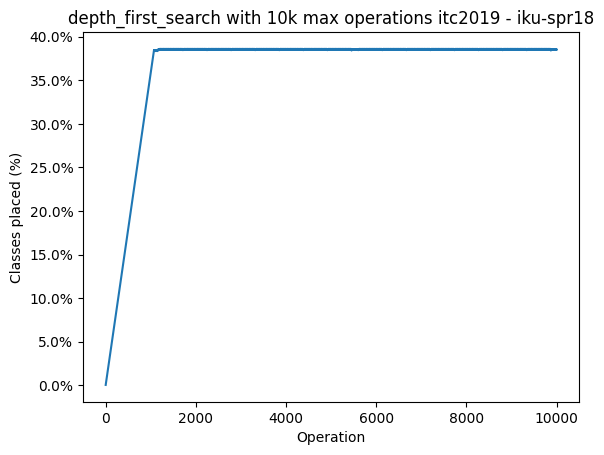

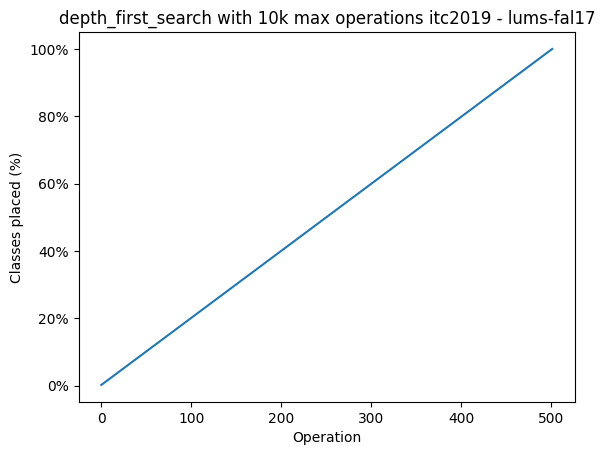

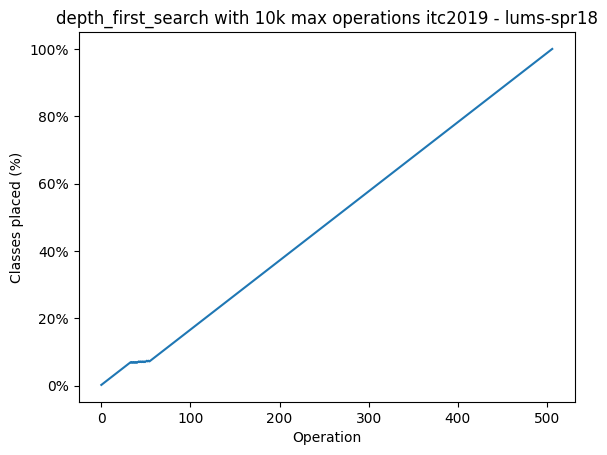

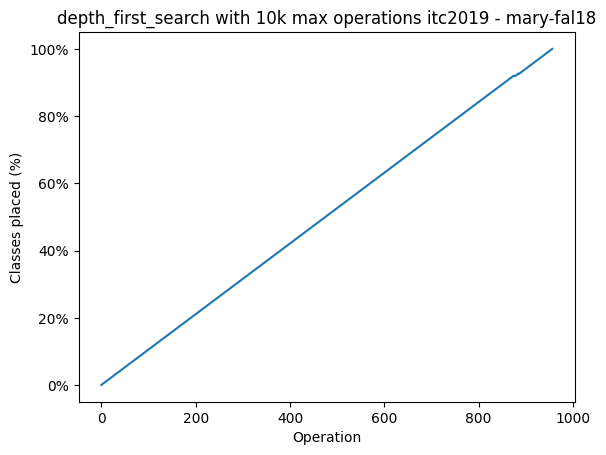

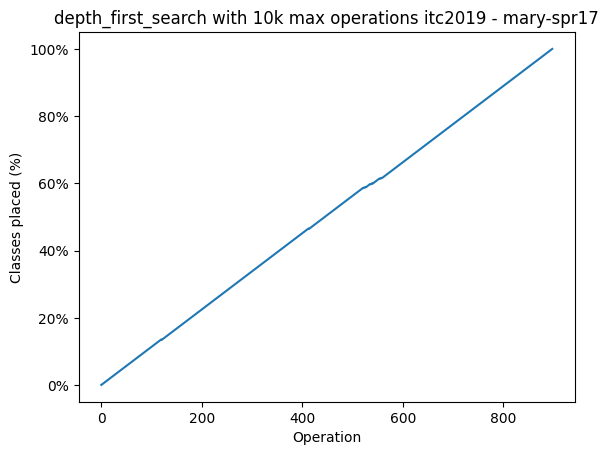

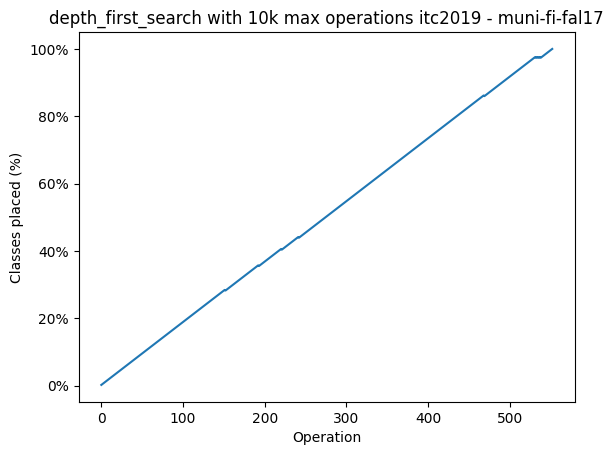

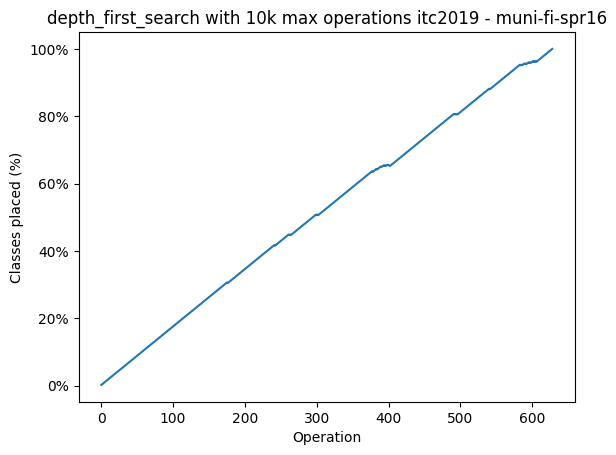

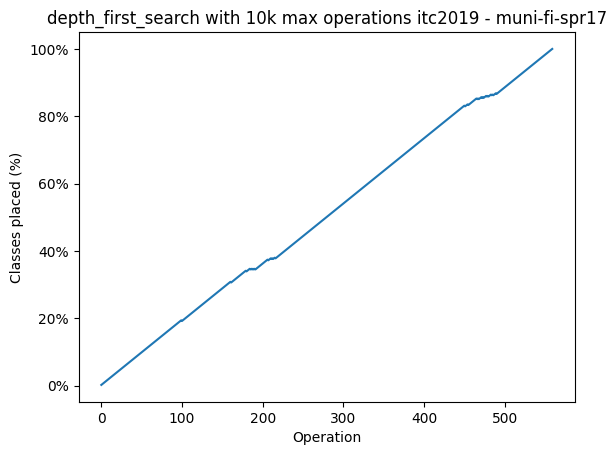

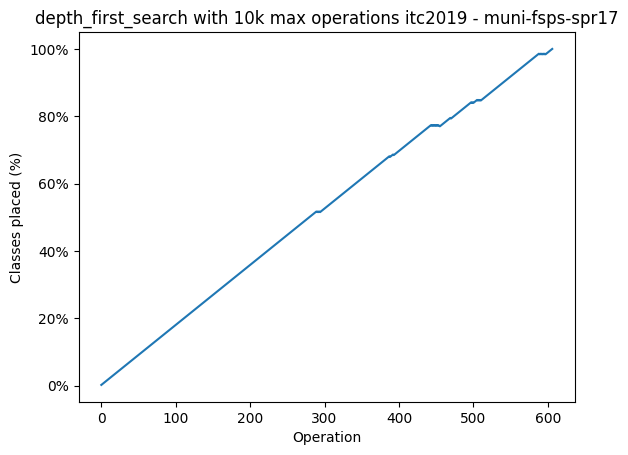

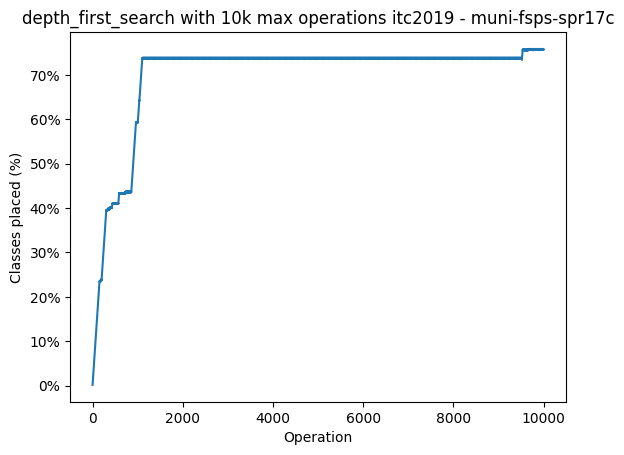

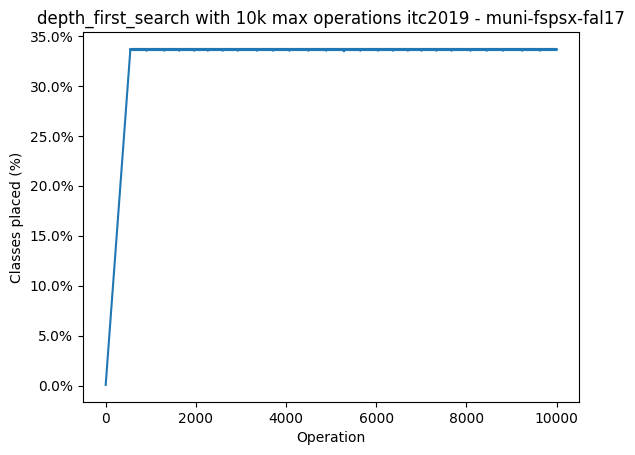

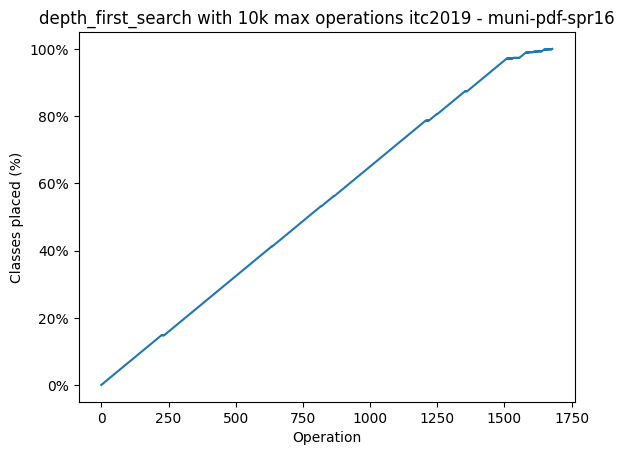

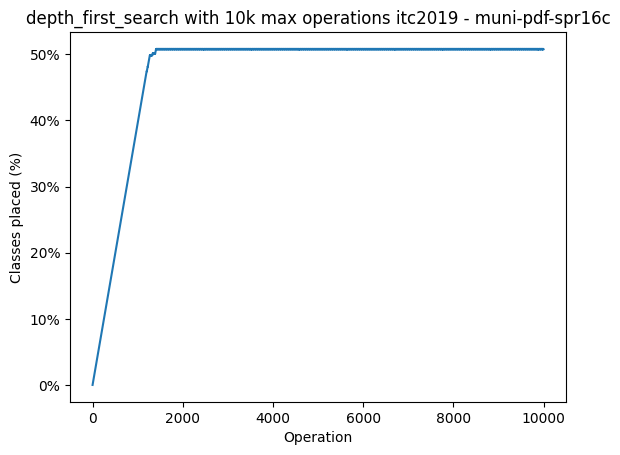

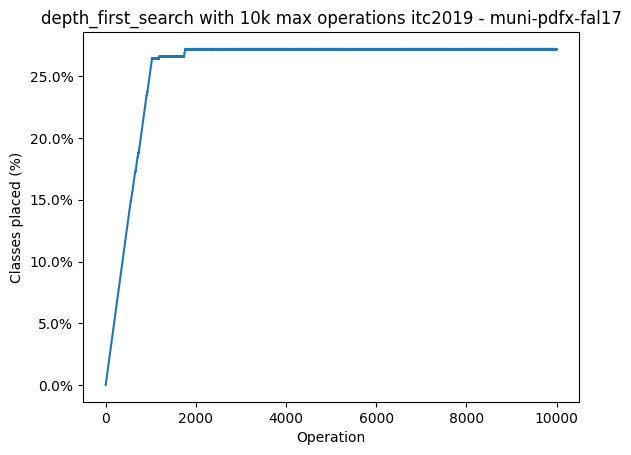

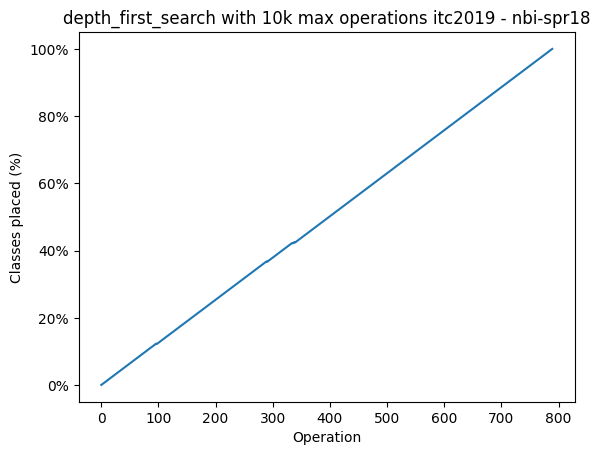

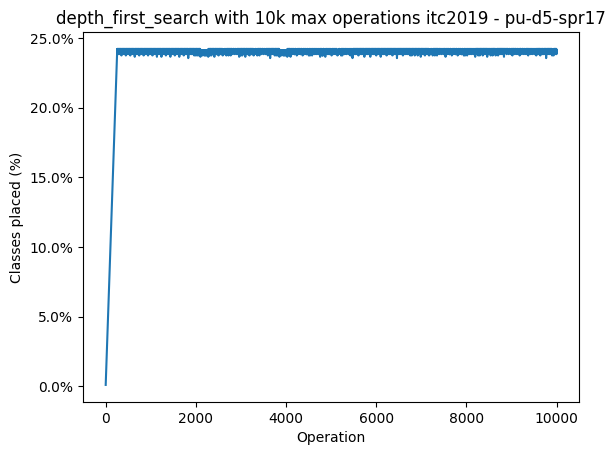

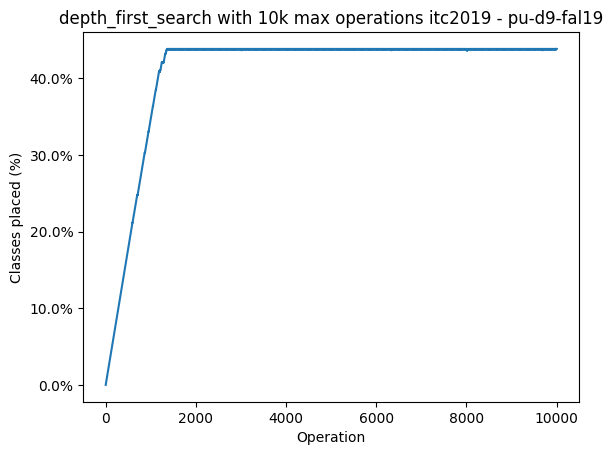

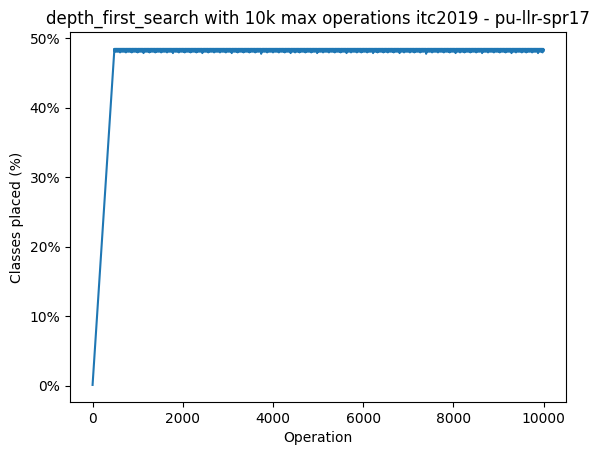

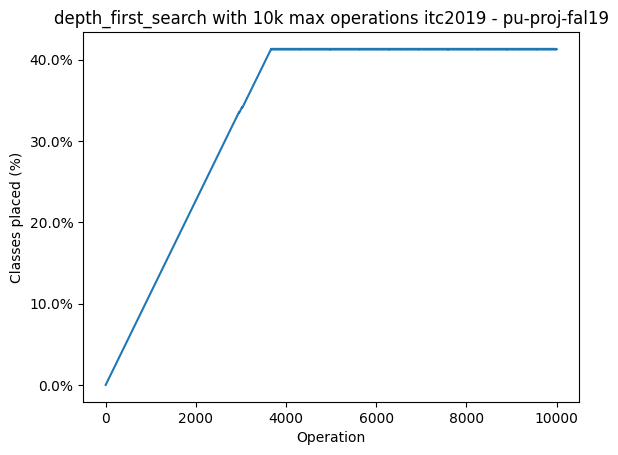

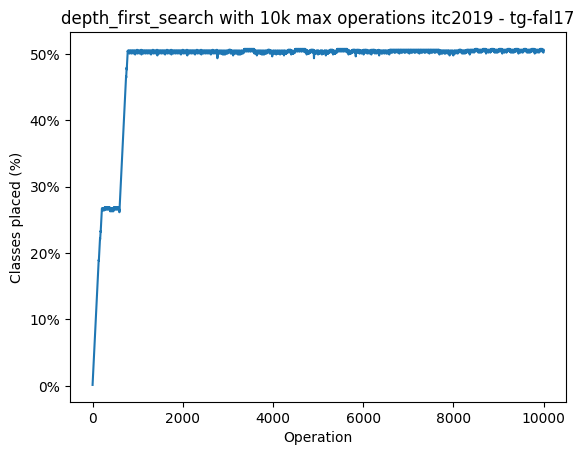

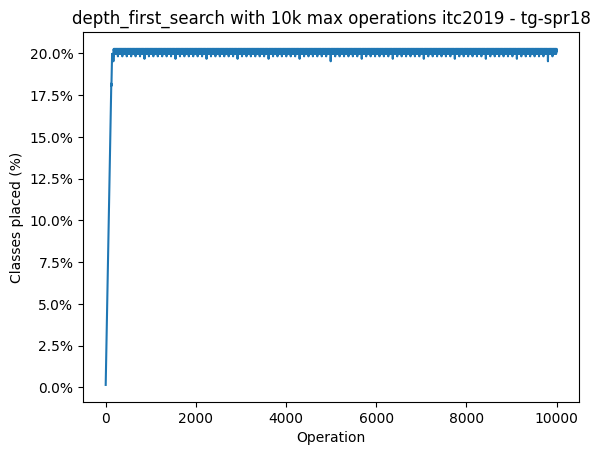

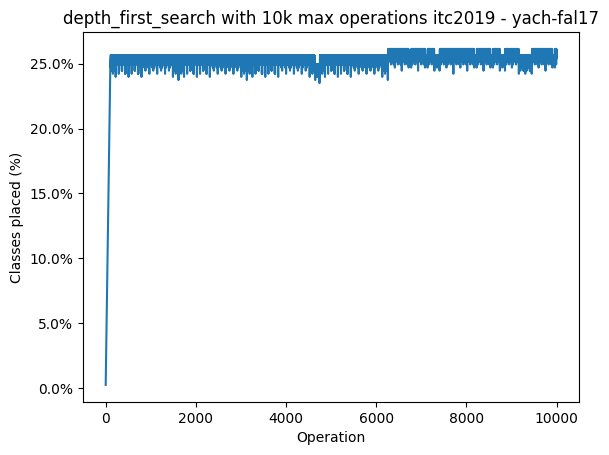

In [15]:

analysis_df['class_count'] = analysis_df.apply(lambda x: len(x['problem'].classes),axis=1)

def plot_percentage_placed_over_operation(file,operation_history,class_count , title):
    fig,ax = plt.subplots()
    ax.set_title(title)
    
    y = [i['current_row'] for i in operation_history]
    y_percent = [i/class_count for i in y]
    
    
    ax.set_xlabel('Operation')
    ax.set_ylabel('Classes placed (%)')
    
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    
    ax.plot(y_percent)
    plt.show()
    
    if file:
        fig.savefig(file + '.png')


_ = analysis_df.apply(
    lambda x: plot_percentage_placed_over_operation(
        os.path.join(x['folder path'],"class_placed_percent_over_operation_graph"),
        x['operation_history'],
        x['class_count'],
        x['experiment_details'].name + " " + x['experiment_details'].dataset_name + ' - '+ x['instance_name'])
    ,axis=1
)
